# Recommending Music Titles

Consumer choices and how they can be influenced are critical factors for every business. For instance, most people are interested in specific music genres, have favorite authors, or engage in particular hobbies. This information can be extracted from their purchase history or product reviews, and when utilized correctly, it can drastically increase the company’s profit. We have all encountered similar functionality on different online platforms that suggest products to buy, news to watch, friends to connect with, jobs to apply to, or restaurants to eat at. These systems fall under the general category of `recommender systems`, which is the topic of this exercise.


We focus on two categories, namely __content-based__ and __collaborative-filtering__ types for creating different music title recommenders using [Snap](https://snap.stanford.edu/data/web-Amazon-links.html).


In [1]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'wget', 'pandas', 'surprise', 'nltk', 'numpy', 'sklearn', 'matplotlib', 'seaborn'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive/ML for Text/Machine-Learning-Techniques-for-Text-main/chapter-05")

The dataset can be downloaded automatically using the following code.

In [4]:
import os
import sys
import wget

# Progress bar for wget.
def progress_bar(current, total, width=80):
  msg = "Downloading: %d%% [%d / %d] bytes" % (current/total*100, current, total)
  sys.stdout.write("\r" + msg)
  sys.stdout.flush()

# Check whether the data file exists (~2GB) and if not download it.
file_exists = os.path.exists("./data/Music.txt.gz")
if not file_exists:
    url = 'https://snap.stanford.edu/data/amazon/Music.txt.gz'
    # The download will take several minutes.
    filename = wget.download(url, out='./data', bar=progress_bar)

## Exploratory data analysis

We start with an exploratory data analysis, as in every machine learning problem. Before we start an in-depth analysis, we extract some basic information from the corpus. We generate different plots to shed some light on the dataset and avoid possible pitfalls in the subsequent analysis.

First, we create the method to obtain the product categories from a file.

In [5]:
import gzip
import pandas as pd

pd.options.mode.chained_assignment = None

# Method for reading the categories file.
def readCategories(filename):
  i, productId, d = 0, '', {}
  f = gzip.open(filename, 'rb')

  # Iterate over all lines in the file.
  for l in f:
    spacesPos = l.find(b' ')
    l = l.strip().decode("latin-1")
    
    # Check whether we are reading a product id or a product category.
    if spacesPos != -1:
      # The categories are separated by a comma.
      for c in l.split(','):
        # Store the category for a specific product.
        d[i] = {'product/productId':productId, 'category':c}
        i += 1
    else:
      productId = l # Store the product id.

  return pd.DataFrame.from_dict(d, columns=['product/productId', 'category'],  orient='index')

We can now call the `readCategories` method for the `categories.txt.gz` file and obtain its data.

In [6]:
df = readCategories('./data/categories.txt.gz')

# Remove duplicate categories for each product.
df = df.drop_duplicates(subset=['product/productId', 'category'], keep='first')

df.head()

,product/productId,category
0,B0027DQHA0,Movies & TV
1,B0027DQHA0,TV
2,B0027DQHA0,Music
3,B0027DQHA0,Classical
4,0756400120,Books


In [7]:
# Merge the categories for each product.
merged = pd.DataFrame(df.groupby('product/productId', as_index=False)['category'].apply(lambda x: "%s" % '|'.join(x)))
merged.columns = ['productId', 'category']

merged.head(5)

,productId,category
0,0000000868,Books| New| Used & Rental Textbooks| Science &...
1,0000020214,Books
2,0000024341,Books
3,0000025240,Books| New| Used & Rental Textbooks| Social Sc...
4,0000038504,Books


The _parseKeysValues_ method, sequentially reads the keys and stores their value.

In [8]:
# Method for reading the keys/values in the file.
def parseKeysValues(filename):
  f = gzip.open(filename, 'rb')
  entry = {}
  
  # Iterate over all lines in the file.
  for l in f:
    l = l.strip()
    # The key/value are separated by a colon.
    colonPos = l.find(b':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    key = l[:colonPos].decode("latin-1")
    value = l[colonPos+2:].decode("latin-1")
    entry[key] = value
  yield entry

We can create a method to read the review data.

In [9]:
# Method for reading the reviews file.
def readReviews(path, num=-1):
  i = 0
  df = {}
  for d in parseKeysValues(path):
    df[i] = d
    i += 1
    if i == num:
      break
  return pd.DataFrame.from_dict(df, orient='index')

The analysis begins by loading the data from the corpus. Calling the _readReviews_ method, we extract _250000_ samples from the dataset.

In [10]:
# Read the reviews from the data.
reviews = readReviews('./data/Music.txt.gz', 250000)
reviews.shape

(250000, 10)

Next, we will perform a couple of transformations on the data to facilitate the analysis.

In [11]:
# Rename the columns for convenience.
reviews.columns = ['productId', 'title', 'price', 'userId', 'profileName', 'helpfulness', 'score', 'time', 'summary', 'text']

# Make the scores float values.
reviews['score'] = reviews['score'].astype(float)

reviews[['productId', 'userId', 'score', 'text']].head(5)

,productId,userId,score,text
0,B00002066I,unknown,5.0,I hope a lot of people hear this cd. We need m...
1,B00002066I,A2KLYVAS0MIBMQ,5.0,My lovely Pat has one of the GREAT voices of h...
2,B000058A81,A18C9SNLZWVBIE,5.0,We've come a long way since the days of Ninete...
3,B000058A81,A38QSOKE2DD8JD,5.0,Final fantasy fans may be at first skeptical o...
4,B000058A81,AKZLIIH3AP4RU,5.0,This has got to be one of the best video game ...


We observer that _userId_ includes the _unknown_ generic value assigned when the user cannot be identified.

The cleaning phase starts with the removal of samples, including the _unknown_ identifier, according to the following code.

In [12]:
# Remove reviews for unknown profiles.
reviews = reviews[reviews['userId'] != 'unknown']
reviews.shape

(202111, 10)

The result suggests that a large portion of the samples included this generic identifier. Also, for a small subset of the samples, there isn’t a title for the product.

In [13]:
# Remove reviews with empty titles.
reviews = reviews[reviews['title'] != '']
reviews.shape

(202066, 10)

Next, we decide to keep only one review for a specific product and user.

In [14]:
# Remove multiple reviews from the same user and product.
reviews = reviews.drop_duplicates(subset=['productId', 'userId'], keep='first')
reviews.shape

(197596, 10)

We will keep one review for a specific title and user.

In [15]:
# Remove multiple reviews from the same user and title.
reviews = reviews.drop_duplicates(subset=['title', 'userId'], keep='first')
reviews.shape

(188837, 10)

Another annoying situation is when a product appears with more than one identifier. In this case, we will keep just one _productId_ per item.

In [16]:
# Keep one product id for titles with multiple ones.
unique_ids = reviews[~reviews.duplicated(['productId', 'title'])] # duplicated will find what are all the duplicates.
unique_ids = unique_ids.drop_duplicates(subset=['title'], keep='first') # from duplicate titles are dropped, only the first one is retained.
reviews = reviews[reviews['productId'].isin(unique_ids['productId'])] # Now, for one product title, we will have just one product id

reviews.shape

(178058, 10)

The names of several titles appear as slightly different versions, as the following example demonstrates.

In [17]:
reviews[reviews['title'].str.contains('Lonely Heart')].drop_duplicates(subset=['title'], keep='first')

,productId,title,price,userId,profileName,helpfulness,score,time,summary,text
84481,B000I26XF6,Sgt. Pepper's Lonely Hearts Club Band,unknown,A17CF6FWOLGIQY,"GREG WALLACE ""GW""",3/3,5.0,1125360000,The Ultimate Psychedelic Sunshine Album,I started collecting Beatle records around the...
198901,B000MU2LJG,Sgt. Peppers Lonely Hearts Club Band,unknown,A1AED3TF9SPA9B,John D.,7/8,1.0,1353628800,Sgt Peppers Lonely Hearts Club Band 2012 Vinyl...,I am sure that a perfectly pressed copy of thi...


Both the rows above essentially convey the same information. The title is the same, but the product id is different. SO, we work on combining both the rows, or easy way is have only one row instead of two. How to do that?

Still, the most straightforward workaround is to only keep one of the multiple versions. For this task, we incorporate the **Levenshtein distance** to extract the similarity between the two titles. This is the topic of the following section.

We can now filter the titles in the dataset.

In [18]:
# Load music items with similar titles.
similar_titles = pd.read_csv("./data/similar_titles.csv", sep='\t')

# Remove similar titles from the dataset.
reviews = reviews[~reviews['title'].isin(similar_titles['title2'])]

reviews.shape

(172160, 10)

The dataset needs to be augmented with a category column.

In [19]:
# Add the category for each item.
reviews = pd.merge(reviews, merged, on='productId', how='left')

reviews[['productId', 'userId', 'score', 'text', 'category']].head()

,productId,userId,score,text,category
0,B00002066I,A2KLYVAS0MIBMQ,5.0,My lovely Pat has one of the GREAT voices of h...,Music| Pop| Rock
1,B000058A81,A18C9SNLZWVBIE,5.0,We've come a long way since the days of Ninete...,Music| Pop| Soundtracks
2,B000058A81,A38QSOKE2DD8JD,5.0,Final fantasy fans may be at first skeptical o...,Music| Pop| Soundtracks
3,B000058A81,AKZLIIH3AP4RU,5.0,This has got to be one of the best video game ...,Music| Pop| Soundtracks
4,B000058A81,A1FELZOGR5DEOM,5.0,I used to find myself starting Chrono Cross ov...,Music| Pop| Soundtracks


There is a portion of the products that are not strictly music-oriented, as we can identify with the following code snippet.

In [20]:
# Check for non specific music-oriented items.
reviews[~reviews['category'].str.startswith("Music")].head(1)

,productId,title,price,userId,profileName,helpfulness,score,time,summary,text,category
196,6301782143,Perfect Gentlemen [VHS],unknown,A2YMQYKW31VGG2,B. Martin,10/11,1.0,1238025600,Not really what I wanted,For anybody who's looking for the 1978 movie w...,Movies & TV| TV|Music| R&B


We decide to exclude these less relevant products.

In [21]:
# Keep the items that are specifically music-oriented.
reviews = reviews[reviews['category'].str.startswith("Music")]

reviews.shape

(162989, 11)

Next, we obtain the number of unique products in the dataset, using their _productId_.

In [22]:
print("Number of product ids in the corpus: " + str(len(reviews['productId'].unique())))

Number of product ids in the corpus: 19453


Let’s now get the different product categories.

In [23]:
import re

# Extract the categories of the music items.
cat = ';'.join(reviews['category'])
cat = [item.lstrip() for item in re.split(';|\|', cat)]
categories = pd.DataFrame(cat, columns=['category'])

categories['category'].unique()

array(['Music', 'Pop', 'Rock', 'Soundtracks', 'Classical', 'World Music',
       'Dance & Electronic', 'New Age', 'Jazz', 'Broadway & Vocalists',
       'Country', 'Folk', 'Blues', 'Classic Rock', 'R&B',
       'Alternative Rock', 'Latin Music', 'Rap & Hip-Hop',
       'Miscellaneous', 'Hard Rock & Metal', "Children's Music",
       'Christian', 'Gospel', 'Musical Instruments',
       'Instrument Accessories', 'General Accessories', 'Patio',
       'Lawn & Garden', 'Pest Control', 'Tools & Home Improvement',
       'Building Supplies', 'Building Materials', 'Doors', 'Garage Doors',
       'Openers & Parts', 'Hardware', 'Keyboard Accessories',
       'Player Piano Accessories'], dtype=object)

Next, we remove _Music_ from the categories and only keep the genres of the products.

In [24]:
# Keep only the genres of the items.
categories = categories[categories['category'] != "Music"]

We can now plot the number of products per genre category.

(array([0]), [Text(0, 0, 'category')])

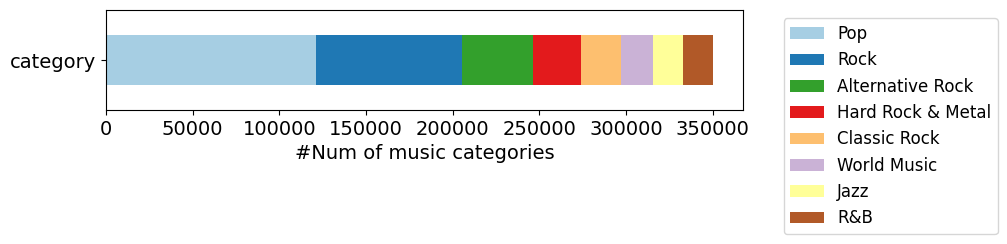

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Get the genres distribution and keep the top 8.
x = categories['category'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:8]

# Plot the distribution.
pd.DataFrame(x).T.plot.barh(stacked=True, colormap='Paired', figsize=(10,2)).legend(bbox_to_anchor=(1.05, 1), fontsize='large')
plt.tight_layout()
plt.xlabel('#Num of music categories', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

A large quantity of the items is labeled _Pop_, followed by _Rock_ and _Alternative Rock_.

this gave the information about how the dataset is present, like the distribution of the genres.

Another interesting piece of information is the distribution of the rating reviews.

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.]),
 [Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

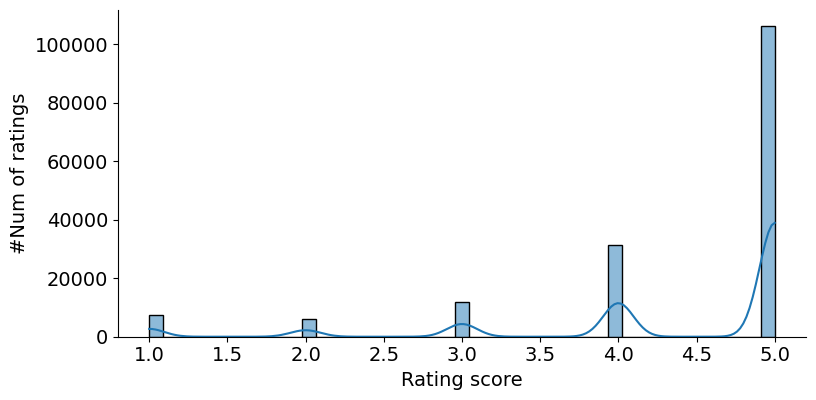

In [26]:
import seaborn as sns

# Create the distribution plot including kernel density estimation.
sns.displot(data=reviews['score'], kde=True, bins=45, height=4, aspect=2)
plt.xlabel('Rating score', fontsize=14)
plt.ylabel('#Num of ratings', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Based on a five scale rating (**1.0** – **5.0**), the largest proportion of the scores falls on the right-hand side of the x-axis – in this example, above or equal to the value of **3.0**. Thus, there is a clear imbalance in the ratings toward positive scores.

Next, we extract rating scores for two random products.

In [27]:
# Calculate the count of reviews per each rating for the two items.
r_count_1 = reviews[reviews['productId']=="B0007NFL1I"].groupby('score')['score'].count()
r_count_2 = reviews[reviews['productId']=="B000I26XF6"].groupby('score')['score'].count()

# Create a dataframe from the data.
r_count = pd.concat([r_count_1.rename('The Massacre [Vinyl]'), r_count_2.rename('Sgt. Pepper\'s Lonely Hearts Club Band')], axis=1)
r_count['rating'] = r_count.index
r_count = pd.melt(r_count, id_vars="rating")

r_count.head(15)

,rating,variable,value
0,1.0,The Massacre [Vinyl],415
1,2.0,The Massacre [Vinyl],113
2,3.0,The Massacre [Vinyl],126
3,4.0,The Massacre [Vinyl],157
4,5.0,The Massacre [Vinyl],238
5,1.0,Sgt. Pepper's Lonely Hearts Club Band,48
6,2.0,Sgt. Pepper's Lonely Hearts Club Band,32
7,3.0,Sgt. Pepper's Lonely Hearts Club Band,68
8,4.0,Sgt. Pepper's Lonely Hearts Club Band,116
9,5.0,Sgt. Pepper's Lonely Hearts Club Band,735


The obtained statistics can assist in the visualization of the ratings and comparison of the two products.

<ipython-input-28-0ba754b1ef74>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=r_count, kind="bar", x="rating", y="value", hue="variable", ci="sd", palette="dark", alpha=.6, height=5, aspect=2)


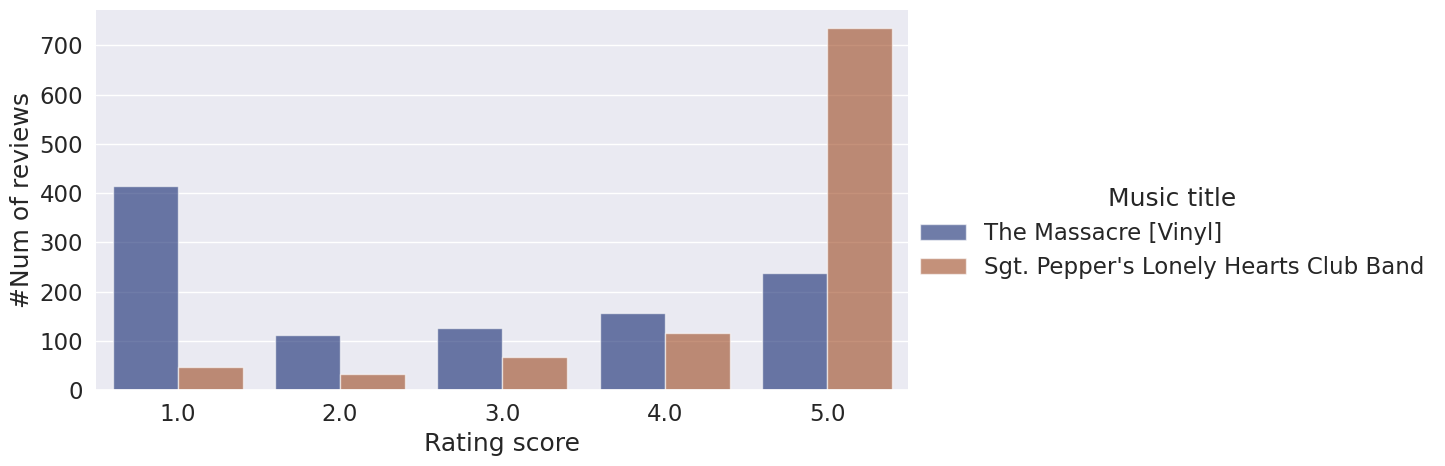

In [28]:
# Create and show the plot.
sns.set(font_scale=1.5)
g = sns.catplot(data=r_count, kind="bar", x="rating", y="value", hue="variable", ci="sd", palette="dark", alpha=.6, height=5, aspect=2)
g.despine(left=True)
g.set_axis_labels("Rating score", "#Num of reviews")
g.legend.set_title("Music title")

Contrasting the two products reveals an asymmetry in their rating scores, as _Sgt. Pepper's Lonely Hearts Club Band_ is perceived more positively than _The Massacre [Vinyl]_.

Descriptive statistics complement data visualizations and provide simple summaries of the observations and their measures. The analysis that follows focuses on the ratings of the products.

In [29]:
import numpy as np

# Calculate the number of ratings per product along with their mean value.
product_stats = reviews.groupby('productId').agg({'score': [np.size, np.mean]}) # The size will give how many reviews are there for each score

# Half of the products (50%) have 2 ratings at most.
product_stats['score']['size'].describe()

count    19453.000000
mean         8.378605
std         34.877318
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1836.000000
Name: size, dtype: float64

In [30]:
product_stats

score          
            size      mean
productId                 
1575832690    10  4.000000
1591963990     3  4.333333
1889212032     1  5.000000
6301421140     8  4.625000
7884982242     1  5.000000
...          ...       ...
B000UPSLDI    13  4.538462
B000UTG65O     2  5.000000
B000UVDEO8     1  4.000000
B000UYCN2Y     1  4.000000
B000V07PVQ     1  3.000000

[19453 rows x 2 columns]

The next step is to obtain the most highly rated products.

In [31]:
# Keep the unique product titles.
unique_titles = reviews[['productId', 'title', 'category']].drop_duplicates(subset='title', keep='first')

Let’s keep those with more than 100 ratings and sort them in descending order.

<ipython-input-32-4832ae206ded>:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  product_ext_1 = unique_titles.set_index('productId').join(m).sort_values(('score', 'size'), ascending=False).dropna()


Text(0, 0.5, 'Music title')

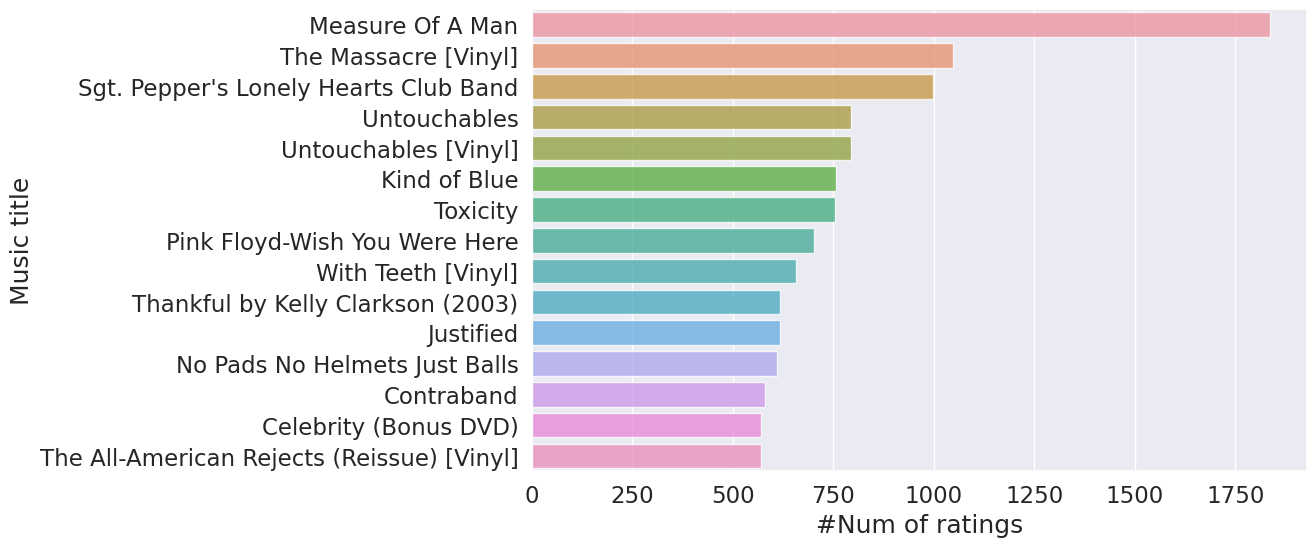

In [32]:
# Focus on products with at least 100 ratings.
product_subset = product_stats['score']['size'] >= 100

# Filter and sort the products based on their rating size.
m = product_stats[product_subset].sort_values([('score', 'size')], ascending=False)
product_ext_1 = unique_titles.set_index('productId').join(m).sort_values(('score', 'size'), ascending=False).dropna()

# Plot the product titles with the most ratings.
sns.barplot(x=product_ext_1[:15][('score', 'size')], y = product_ext_1[:15]['title'], alpha=0.8)
plt.gcf().set_size_inches(10, 6)
plt.xlabel('#Num of ratings')
plt.ylabel('Music title')

Next we investigate whether there is any mathematical basis for the most-rated movies having higher rating values. The focus is on two variables; namely, the number of ratings and the mean rating score, defined in the following code.

In [33]:
# Filter and sort the products based on their mean rating.
m_rating = product_stats[product_subset].sort_values([('score', 'mean')], ascending=False)
product_ext_2 = unique_titles.set_index('productId').join(m_rating).sort_values(('score', 'mean'), ascending=False).dropna()

# Create a new dataframe with the two variables.
m = pd.DataFrame()
m['size'] = product_ext_1[('score', 'size')]
m['mean'] = product_ext_2[('score', 'mean')]

# Calculate the correlation between the two variables.
m.corr(method='pearson')

<ipython-input-33-9694425190b1>:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  product_ext_2 = unique_titles.set_index('productId').join(m_rating).sort_values(('score', 'mean'), ascending=False).dropna()


,size,mean
size,1.000000,-0.067582
mean,-0.067582,1.000000


The calculated value equal to **-0.067582** signifies that there is no linear correlation between the two variables, which we can also visualize using the following code.

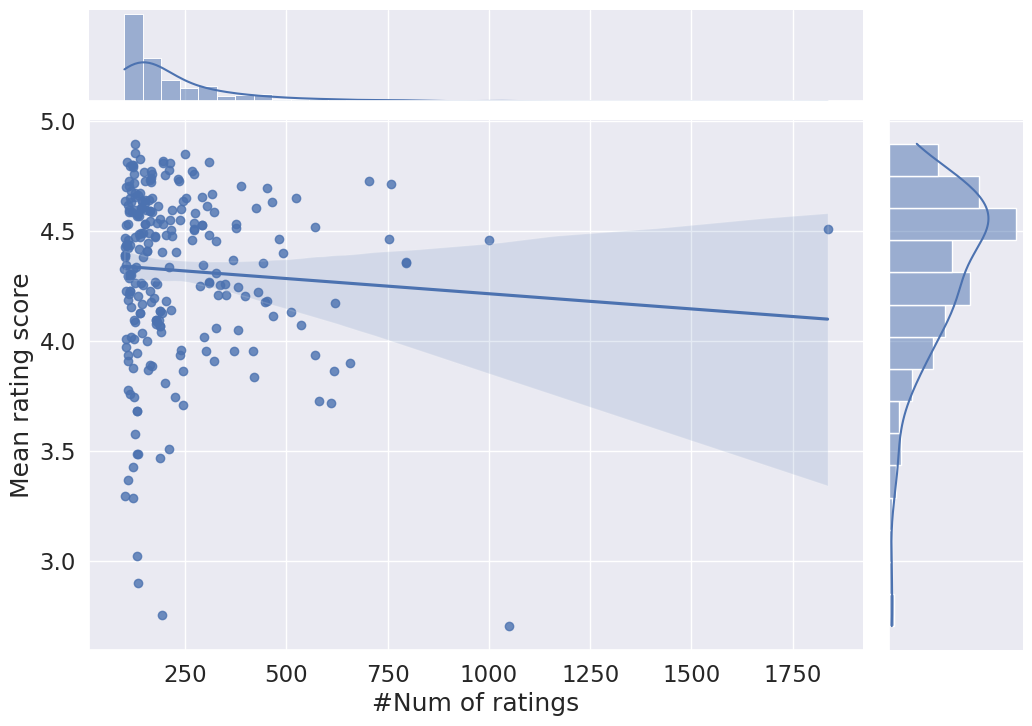

In [34]:
# Show the joint plot for rating size and mean.
g = sns.jointplot(x='size', y='mean', kind='reg', data=m)
g.set_axis_labels('#Num of ratings', 'Mean rating score')
plt.gcf().set_size_inches(12, 8)

According to the plot, items with around **750** ratings have a mean score in the area of **4.5** points. The regression line shows the relationship between the two variables and its slope indicates how changes in the variable on the x-axis affect the variable on the y-axis.

## Content based filtering

Systems based on content-based filtering exploit the items' properties to recommend new products with similar features. 

We create a bag of words for each music item containing its review text and genres. We call it `metadata`.

In [35]:
# Group all tags per product id.
product_tags = pd.DataFrame(reviews.groupby('productId')['summary'].apply(lambda x: "%s" % ' '.join(x)))

# Include the tags in the product dataframe.				  
products = pd.merge(unique_titles, product_tags, on='productId', how='left')

# Create product metadata that consists of tags and genres.
products['genres'] = products['category'].str.replace('|',' ')
products['metadata'] = products[['summary', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

products[['title', 'metadata']][50:55]

<ipython-input-35-075222f02520>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  products['genres'] = products['category'].str.replace('|',' ')


,title,metadata
50,Hard Hard Traveling Man,Fantastic!! The Best !!!! Country Singer From ...
51,Memorial Album 7,A Great Cd filled with REAL Sailor Moon Songs!...
52,Accesories- Rarities And B-Sides,The Gathering hands out their bag of goodies f...
53,Sweet Nothing,Australia's best-kept secret is an absolute tr...
54,The Formula,80's synth-rock for......the thinking man. (An...


In [36]:
products

,productId,title,category,summary,genres,metadata
0,B00002066I,ah,Music| Pop| Rock,Great CD,Music Pop Rock,Great CD Music Pop Rock
1,B000058A81,Chrono Cross: Original Soundtrack,Music| Pop| Soundtracks,First album I've bought since Napster Pleasant...,Music Pop Soundtracks,First album I've bought since Napster Pleasant...
2,B00000C3P2,SOR: Guitar Music Opp.10-12 Complete Guitar Mu...,Music| Classical,One of My Favorites Naxos Sor Discs SOR Guitar...,Music Classical,One of My Favorites Naxos Sor Discs SOR Guitar...
3,B000058A8F,Vagrant Story: Original Soundtrack,Music| Pop| Soundtracks,Full track listing The Best Soundtrack By Squa...,Music Pop Soundtracks,Full track listing The Best Soundtrack By Squa...
4,B00009LW26,Aw,Music| Pop| World Music,Impressionnant! A really great CD,Music Pop World Music,Impressionnant! A really great CD Music Pop ...
...,...,...,...,...,...,...
19448,B00005KBAE,20th Century Masters:The Best of Scorpions Mil...,Music| Classic Rock| Classical| Hard Rock & Me...,"Good for a new fan Hilarious, funniest CD ever...",Music Classic Rock Classical Hard Rock & Me...,"Good for a new fan Hilarious, funniest CD ever..."
19449,B000000GDD,Country Guitar Flavors,Music| Classical| Country| Pop,Lovely guitar,Music Classical Country Pop,Lovely guitar Music Classical Country Pop
19450,B0000668G2,Smooth & Tropic,Music| Jazz| New Age| Pop| World Music,"McCaffrey McCaffrey, Smooth &amp; tropic McCaf...",Music Jazz New Age Pop World Music,"McCaffrey McCaffrey, Smooth &amp; tropic McCaf..."
19451,B000001C0X,Great Speeches 1,Music| Miscellaneous| Pop,You have to admire this man CAUTION - Mis Adve...,Music Miscellaneous Pop,You have to admire this man CAUTION - Mis Adve...


For representing the text in metadata we will use tf-idf and reduce its dimensionality with `Latent Semantic Analysis` (SVD).

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Generate the tf-idf matrix for the data set.
tfidf = vectorizer.fit_transform(products['metadata'])

# Create a dataframe from the matrix.
tfidf_data = pd.DataFrame(tfidf.toarray(), index=products.index.tolist())

tfidf_data.shape

(19453, 14896)

Each of the **19453** unique products is represented with an array of **14896** values.

Next, we apply SVD to reduce the column size using **200** components.

In [38]:
# Calculate 200 components for the tfidf dataframe.
svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

# Calculate the latent matrix.
latent = svd.fit_transform(tfidf_data)

# Create the latent dataframe.
latent_data = pd.DataFrame(latent, index=products['title'].tolist())

latent_data.shape

(19453, 200)

A vector with **200** components describes now each of the **19453** products, all included in the _latent_data_. The latter can be used to recommend similar items for a music title based on the Euclidean distance, the Pearson's correlation, or the cosine similarity between two vectors in the dataframe. As an example, we choose the _Led Zeppelin [Vinyl]_ title from an famous group and incorporate the cosine similarity method. 

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Obtain the latent vector for a product.
led_zeppelin = np.array(latent_data.loc['Led Zeppelin [Vinyl]']).reshape(1, -1)

# Calculate the similarity of the product with the other ones.
similarity = cosine_similarity(latent_data, led_zeppelin).reshape(-1)

# Create the dataframe from the array.
similarity_data = pd.DataFrame(similarity, index=latent_data.index, columns=['measure'])

# Obtain the 10 top recommendations.
recommend = similarity_data.sort_values('measure', ascending=False).head(11)

# Get the title and genre for the recommendations.
tg = products[products['title'].isin(recommend.index.tolist())][['title', 'category']]

# Join the information from the two dataframes.
recommend = tg.set_index('title').join(recommend, how='left', lsuffix='_left', rsuffix='_right')

# Recommend 10 products. 
recommend = recommend.sort_values('measure', ascending=False)
recommend[~recommend.index.duplicated(keep='first')]

,category,measure
title,,
Led Zeppelin [Vinyl],Music| Classic Rock| Hard Rock & Metal| Rock,1.000000
In the Heat of the Night,Music| Classic Rock| Hard Rock & Metal| Pop| Rock,0.852006
Definitely Maybe,Music| Alternative Rock| Hard Rock & Metal| Po...,0.851303
Tuesday Night Music Club,Music| Rock,0.840619
Garth Brooks,Music| Country| Pop,0.809610
Innoncence Is Running Out,Music| Rock,0.808551
Ritchie Blackmore's Rainbow (Limited Edi,Music| Rock,0.806990
When Dream & Day Unite,Music| Hard Rock & Metal| Pop| Rock,0.798694
Bon Jovi,Music| Classic Rock| Hard Rock & Metal| Pop| Rock,0.781751


It’s reassuring that the most similar result (the first element in the output) is the _Led Zeppelin [Vinyl]_ title. The system seems to work quite well, as many products are related to the reference item, whether in the _Rock_ genre or another relevant variation. Then, we will repeat the previous process using the _Mozart: Fantasias & Sonatas_ title as input.

In [40]:
# Obtain the latent vector for a product.
mozart = np.array(latent_data.loc['Mozart: Fantasias & Sonatas']).reshape(1, -1)

# Calculate the similarity of the product with the other ones.
similarity = cosine_similarity(latent_data, mozart).reshape(-1)

# Create the dataframe from the array.
similarity_data = pd.DataFrame(similarity, index=latent_data.index, columns=['measure'])

# Obtain the 10 top recommendations.
recommend = similarity_data.sort_values('measure', ascending=False).head(11)

# Get the title and genre for the recommendations.
tg = products[products['title'].isin(recommend.index.tolist())][['title', 'category']]

# Join the information from the two dataframes.
recommend = tg.set_index('title').join(recommend, how='left', lsuffix='_left', rsuffix='_right')

# Recommend 10 products. 
recommend = recommend.sort_values('measure', ascending=False)
recommend[~recommend.index.duplicated(keep='first')]

,category,measure
title,,
Mozart: Fantasias & Sonatas,Music| Classical,1.000000
Mozart- Harnoncourt: The Late Symphonies Nos. 31-41,Music| Classical,0.987406
Symphonies 1-15 / Philharmonic Symphony Orchestra of London / Erich Leinsdorf (MCA) (2 CDS),Music| Classical,0.987111
Schnabel Plays Mozart,Music| Classical,0.984056
Romantic Moments Vol. 1: Mozart,Music| Classical,0.981416
Zukerman Conducts Mozart,Music| Classical,0.979731
"Mozart: Le Nozze di Figaro (The Marriage of Figaro) [New York -- January 29, 1944; Steber, Sayao, Novotna, Brownlee, Pinza, Baccaloni; Bruno Walter]",Music| Classical,0.979172
"Mozart: Symphony No, 40 K 550 & Piano Concerto No, 20 K 466",Music| Classical,0.974895
Mozart: Bastien und Bastienne,Music| Classical| Pop,0.961341


This time, the recommendation list only contains titles from the same composer, while the measure values are higher than in the previous example.

## Collaborative filtering

Collaborative filtering relies on mutual preferences as it identifies items that a user might like based on how other similar users rated them. There are two methods for implementing collaborative filtering systems: `memory-based` and `model-based`. In the first case, we utilize user rating data to compute the similarity between users or items. In the second case, models are developed incorporating machine learning algorithms to predict users' ratings of unrated items. Let's see both in more detail, starting from the memory-based approach.

### Memory-based collaborative recommender

Before implementing the recommender, we need to sort out the data. A design choice is to utilize instances from reviewers with at least _5_ evaluations. 

In [41]:
reviews

,productId,title,price,userId,profileName,helpfulness,score,time,summary,text,category
0,B00002066I,ah,15.99,A2KLYVAS0MIBMQ,Stephen McClaning,0/0,5.0,1332288000,Great CD,My lovely Pat has one of the GREAT voices of h...,Music| Pop| Rock
1,B000058A81,Chrono Cross: Original Soundtrack,unknown,A18C9SNLZWVBIE,A reader,1/1,5.0,1096934400,First album I've bought since Napster,We've come a long way since the days of Ninete...,Music| Pop| Soundtracks
2,B000058A81,Chrono Cross: Original Soundtrack,unknown,A38QSOKE2DD8JD,Christopher Walden,1/1,5.0,1088121600,"Pleasant to the ear, musical masterpiece",Final fantasy fans may be at first skeptical o...,Music| Pop| Soundtracks
3,B000058A81,Chrono Cross: Original Soundtrack,unknown,AKZLIIH3AP4RU,IcemanJ,1/1,5.0,1075939200,Much more than a game Soundtrack.,This has got to be one of the best video game ...,Music| Pop| Soundtracks
4,B000058A81,Chrono Cross: Original Soundtrack,unknown,A1FELZOGR5DEOM,Shadow,1/1,5.0,1035417600,Amazing!,I used to find myself starting Chrono Cross ov...,Music| Pop| Soundtracks
...,...,...,...,...,...,...,...,...,...,...,...
172155,B00008BXJ0,Escapology,unknown,A19QN0VHUZ35ET,"A fan in North Palm Beach, FL",0/1,5.0,1050019200,Awesome CD,"Having never heard of Robbie Williams before, ...",Music| Pop| Rock
172156,B00008BXJ0,Escapology,unknown,A3TKTAAEBSBBV7,"J. C. Steuber ""Kaxxar the fox""",0/1,4.0,1049846400,"OK, Robbie, you've made me a fan all over again",One of the great mysteries of the universe is ...,Music| Pop| Rock
172157,B00008BXJ0,Escapology,unknown,A32DCDJEGC29V1,Steven,9/22,1.0,1050451200,"Words can't really describe how awful this is,...",I've known about Robbie since before 1995 when...,Music| Pop| Rock
172158,B00008BXJ0,Escapology,unknown,A2CEJO2YSOH5XF,Helen Moody,0/5,3.0,1049587200,Escapolgy an escape,I found this cd a little short of pizzaz. It's...,Music| Pop| Rock


In [42]:
# Keep reviewers with more than 5 reviews.
v = reviews['userId'].value_counts()
reviews = reviews[reviews['userId'].isin(v.index[v.gt(5)])] # only the users who have given more than 5 reviews, thereby etxrating only the active users

reviews.shape

(29687, 11)

With _29687_ reviews at our disposal, we can extract the unique product IDs.

In [43]:
unique_products = reviews.drop_duplicates(subset=['productId'], keep='first')

The pivot table summarizes the rating of each product (row) and each user (column).

In [44]:
# Keep the ratings for the products of interest.
ratings = reviews[reviews['productId'].isin(unique_products['productId'].tolist())]
ratings = ratings[['productId', 'userId', 'score']]

# Reshape data based on column values.
ratings_pivot = ratings.pivot(index=['productId'], columns='userId', values='score').fillna(0)

ratings_pivot


userId,A1020L7BWW9RAX,A103KNDW8GN92L,A103W7ZPKGOCC9,A105S56ODHGJEK,A1075MZNVRMSEO,A10872FHIJAKKD,A10H24TDLK2VDP,A10IDVD9INU6FP,A10W40DOIE1EOP,A10XJR7CWHNKWU,...,AZ0JE672Z45T7,AZ39SOZT3NZQU,AZ4HSDCAGDKFG,AZC562U18BK2S,AZD7NEVKD2GBX,AZDL23124GWH3,AZDVOFC2MTIM5,AZKXH0J59TK11,AZSN1TO0JI87B,AZX0R6GC9106N
productId,,,,,,,,,,,,,,,,,,,,,
1889212032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9051861079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000030A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000030D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000TP5TAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000UGG5KS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000UPSLDI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We observe that the pivot table has many zero values in it and is therefore sparse. Moreover, it contains ratings for _8684_ products and _2191_ reviewers.

Next, we will use the `Pearson correlation` to measure similarity among the _8684_ products.

In [45]:
# Calculate the correlation coefficients.
corr_coef = np.corrcoef(ratings_pivot)
pd.DataFrame(corr_coef)

,0,1,2,3,4,5,6,7,8,9,...,8674,8675,8676,8677,8678,8679,8680,8681,8682,8683
0,1.000000,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,-0.000457,-0.000457
1,-0.000457,1.000000,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,-0.000457,-0.000457
2,-0.000457,-0.000457,1.000000,-0.000457,-0.000457,-0.000457,-0.000457,1.000000,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,-0.000457,-0.000457
3,-0.000457,-0.000457,-0.000457,1.000000,-0.000457,1.000000,-0.000457,-0.000457,-0.000457,1.000000,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,-0.000457,-0.000457
4,-0.000457,-0.000457,-0.000457,-0.000457,1.000000,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,-0.000457,-0.000457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,1.000000,-0.000646,-0.000837,-0.000457,-0.000457
8680,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,-0.000646,...,-0.000914,-0.000646,-0.001293,-0.000646,-0.001285,-0.000646,1.000000,-0.001184,-0.000646,-0.000646
8681,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,-0.000837,...,-0.001184,-0.000837,0.304262,-0.000837,-0.001665,-0.000837,-0.001184,1.000000,-0.000837,-0.000837
8682,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,-0.000457,...,-0.000646,-0.000457,-0.000914,-0.000457,-0.000908,-0.000457,-0.000646,-0.000837,1.000000,-0.000457


We can now extract the correlation of the _Led Zeppelin [Vinyl]_ title with the other ones and sort the output in descending order.

In [46]:
# Obtain the coefficients for a product.
led_zeppelin = corr_coef[list(unique_products['title']).index('Led Zeppelin [Vinyl]')]
print(len(led_zeppelin))

# Obtain the recommendations.
recommend = pd.DataFrame({'title': unique_products['title'].tolist(),
            'category': unique_products['category'].tolist(), 'measure': led_zeppelin}) # adding the names to the correlation scores of that product with other products.

recommend = recommend.sort_values(by=['measure'], ascending = False) # Sort in the descending order
recommend.set_index('title')

# Recommend 10 products.
recommend.head(11)

8684


,title,category,measure
5479,Led Zeppelin [Vinyl],Music| Classic Rock| Hard Rock & Metal| Rock,1.000000
4615,Symphony 0,Music| Classical,0.615228
6123,Slaughter of the Soul,Music| Pop| Rock,0.615228
4635,Native Sons,Music| Alternative Rock| Pop| Rock,0.615228
5739,Living Proof: Mgm Recordings 1963-1975,Music| Classic Rock| Country| Hard Rock & Meta...,0.615228
1567,Island [Vinyl],Music| New Age| Pop| Rock| World Music,0.615228
7997,Whammy! [Vinyl],Music| Alternative Rock| Pop| Rock,0.615228
3386,Structures,Music| Alternative Rock| Dance & Electronic,0.527255
4378,Raisin Cain,Music| Blues| Classic Rock| Hard Rock & Metal|...,0.492025
404,La bella dormente nel bosco,Music| Classical,0.480028


The list contains related _Rock_ music products but lower _measure_ scores than those in the content-based filtering part.

Continuing this line of discussion, let us apply SVD to the rating pivot table and obtain the latent vectors of the products.

In [47]:
# Calculate 200 components for the pivot table.
svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

# Calculate the latent matrix.
latent = svd.fit_transform(ratings_pivot)

# Create the latent dataframe.
latent_data = pd.DataFrame(latent, index=unique_products['title'].tolist())

latent_data.shape

(8684, 200)

Each of the _8684_ unique products is now represented by a vector with 200 elements. Next, we calculate the distance between the reference product and all the others using cosine similarity to obtain candidate recommendations.

In [48]:
# Obtain the latent vector for a product.
led_zeppelin = np.array(latent_data.loc['Led Zeppelin [Vinyl]']).reshape(1, -1)

# Calculate the similarity of the product with the other ones.
similarity = cosine_similarity(latent_data, led_zeppelin).reshape(-1)

# Create the dataframe from the array.
similarity_df = pd.DataFrame(similarity, index=latent_data.index, columns=['measure'])

# Obtain the 10 top recommendations.
recommend = similarity_df.sort_values('measure', ascending=False).head(11)

# Get the title and genre for the recommendations.
tg = unique_products[unique_products['title'].isin(recommend.index.tolist())][['title', 'category']]

# Join the information from the two dataframes.
recommend = tg.set_index('title').join(recommend, how='left', lsuffix='_left', rsuffix='_right')

# Recommend 10 products. 
recommend.sort_values('measure', ascending=False)

,category,measure
title,,
Led Zeppelin [Vinyl],Music| Classic Rock| Hard Rock & Metal| Rock,1.000000
Symphony 0,Music| Classical,0.907534
Native Sons,Music| Alternative Rock| Pop| Rock,0.907534
Slaughter of the Soul,Music| Pop| Rock,0.907534
Structures,Music| Alternative Rock| Dance & Electronic,0.907495
Joy of Christmas,Music,0.891911
La bella dormente nel bosco,Music| Classical,0.885290
Tao of Mad Phat Fringe Zones,Music| Jazz| Pop| R&B,0.866656
Lotusland / Sleeping Forest / Violin Sonata,Music| Classical,0.863544


Notice that the values for the measure scores are now much higher. Once more, reducing the dimensions of the problem is beneficial to the outcome.

### Clustering handwritten text

The [optical recognition of the handwritten digits datasets](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) contains different images for 10 classes of digits (0 to 9). The samples have been size-normalized, centered in a fixed-size image, and made available through the _scikit-learn_ library. We will use this dataset to learn about a model for clustering digits.

So, first, let’s load the samples.

In [49]:
from sklearn.datasets import load_digits

# Load the digits dataset.
digits = load_digits()
digits.data.shape

(1797, 64)

The dataset consisted of _1797_ instances with _64_ features each.

We organize this information in a convenient _dataframe_ structure along with the _target_ classes to facilitate the processing that follows.

<Figure size 640x480 with 0 Axes>

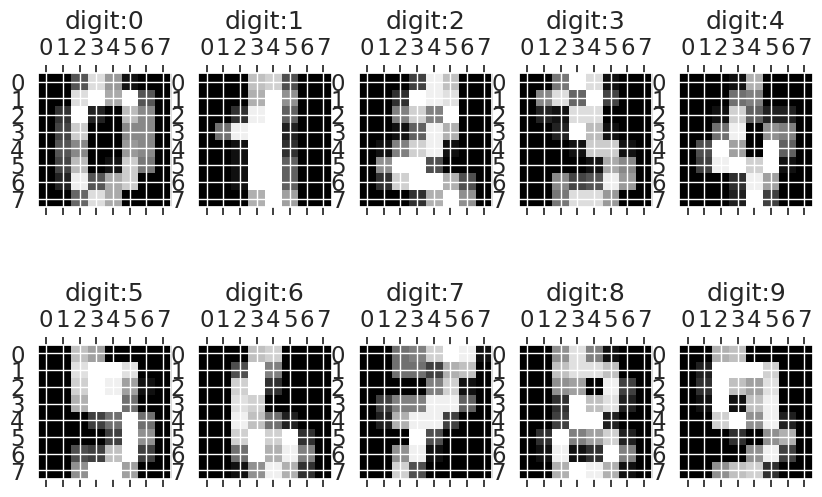

In [50]:
# Create unique ids for the 64 pixels of each image.
pixel_ids = [str(i) for i in range(digits.data.shape[1])]

# Create a dataframe from the data.
df = pd.DataFrame(digits.data, columns=pixel_ids)
df['target'] = digits.target
df['digit'] = df['target'].apply(lambda i: str(i))

# Plot 10 sample digit images.
plt.gray()
fig = plt.figure(figsize=(10, 10))
for i in range(0, 10):
    ax = fig.add_subplot(3, 5, i+1, 
title="digit:"+str(df.loc[i, 'digit']) )
    ax.matshow(df.loc[i, pixel_ids].values.reshape((8, 8)).astype(float))

Let us now incorporate the familiar PCA method using three components.

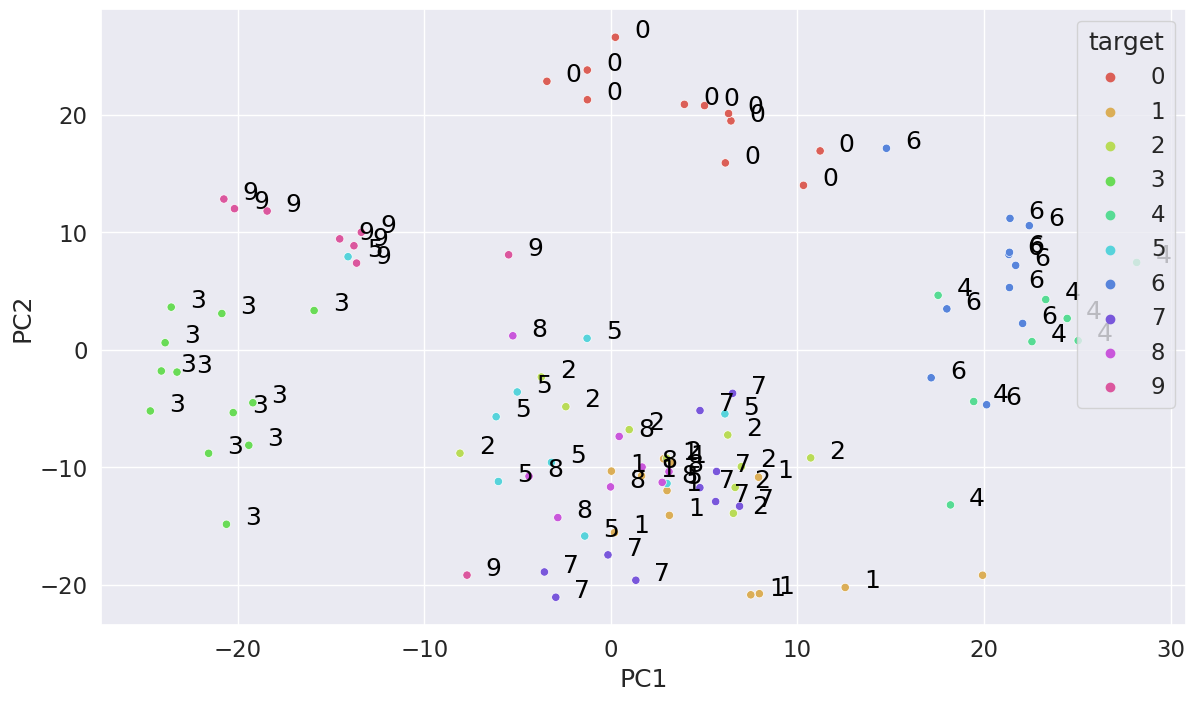

In [51]:
from sklearn.decomposition import PCA

# Calculate 3 principal components.
pca = PCA(n_components=3)
pcaComponents = pca.fit_transform(df[pixel_ids].values)
df['PC1'] = pcaComponents[:, 0]
df['PC2'] = pcaComponents[:, 1] 
df['PC3'] = pcaComponents[:, 2]

# Keep only 100 examples for demonstration.
df_sub = df[:100]

# Create the plot.
plt.figure(figsize=(14, 8))
p = sns.scatterplot(x="PC1", y="PC2", hue="target",
    palette=sns.color_palette("hls", 10),
    data=df_sub, legend="full")

# Include the digit label for each datapoint.
for i in range(0, len(df_sub.index)-1):
     p.text(df_sub['PC1'].iloc[i]+1.0, df_sub['PC2'].iloc[i], 
df_sub['digit'].iloc[i], horizontalalignment='left', size='medium', color='black', weight='normal')

According to the plot, certain digit classes are separated quite well – for example, **0**, **3**, and **9** – but others are entirely mixed – for instance, **2**, **5**, and **7**. 

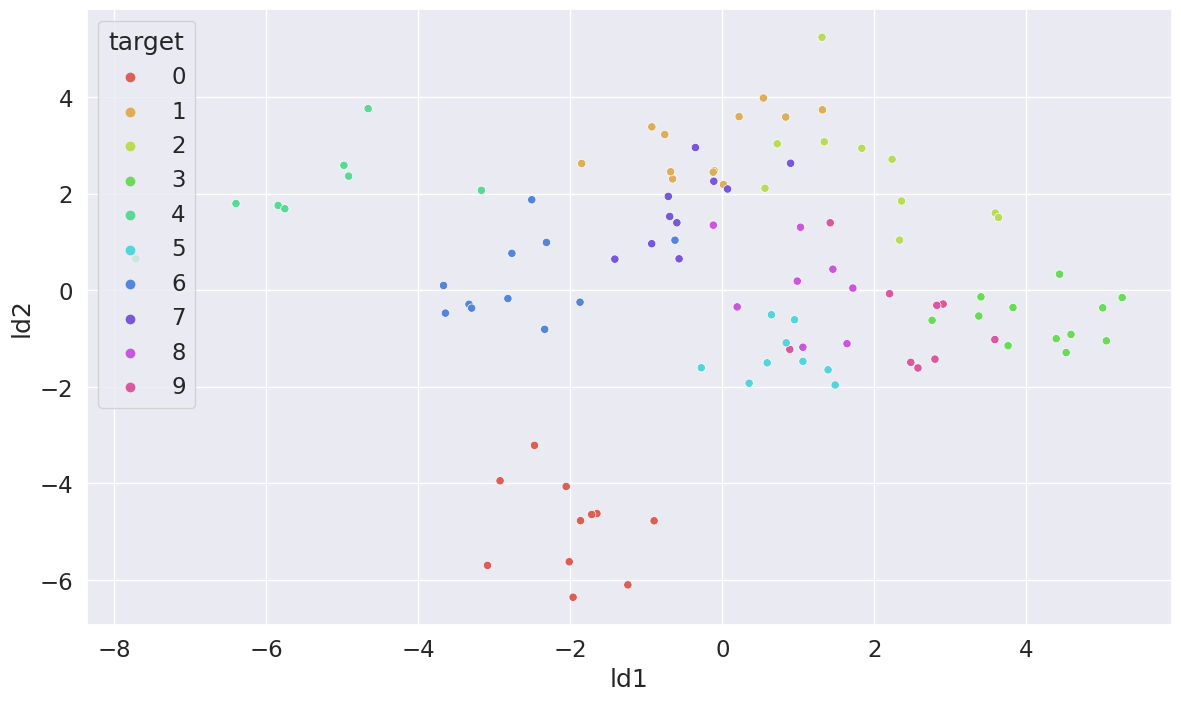

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Calculate 2 principal components.
lda = LinearDiscriminantAnalysis(n_components=3)
ldaComponents = lda.fit(df[pixel_ids].values, df['target'])
ldaComponents = lda.transform(df[pixel_ids].values)

df['ld1'] = ldaComponents[:, 0]
df['ld2'] = ldaComponents[:, 1]
df['ld3'] = ldaComponents[:, 2]

df_sub = df[:100]

# Create the plot.
plt.figure(figsize=(14, 8))
p = sns.scatterplot(x="ld1", y="ld2", hue="target",
    palette=sns.color_palette("hls", 10),
    data=df_sub, legend="full")

# Include the digit label for each datapoint.
#for i in range(0, len(df_sub.index)-1):
#     p.text(df_sub['PC1'].iloc[i]+1.0, df_sub['PC2'].iloc[i], 
#df_sub['digit'].iloc[i], horizontalalignment='left', size='medium', color='black', weight='normal')


We can see that LDA has done quite a good task in separating the labels bcoz the main goal of Lda is that maximum the separation between the two classes. But still we can see that there are some overlaps, lets now discuss more powerful tool for dimensionality reduction which helps in data visualization.

We introduce another dimensionality reduction technique called `t-distributed Stochastic Neighbor Embedding` (t-SNE), which embeds the data points from a higher dimension to a lower one. We apply t-SNE to the digit classification problem using two components.

<Axes: xlabel='tsne1', ylabel='tsne2'>

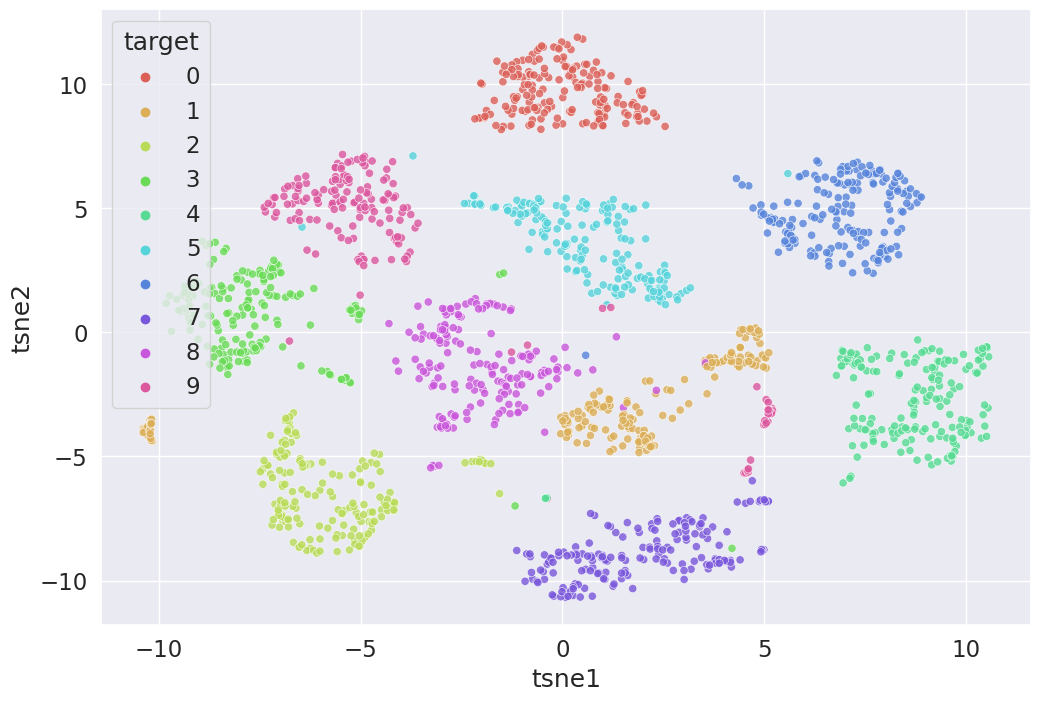

In [53]:
from sklearn.manifold import TSNE

# Calculate 2 tsne components.
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=123)
tsneEmbedded = tsne.fit_transform(df[pixel_ids].values)
df['tsne1'] = tsneEmbedded [:, 0]
df['tsne2'] = tsneEmbedded [:, 1]

# Create the plot.
plt.figure(figsize=(12,8))
sns.scatterplot(x="tsne1", y="tsne2", hue="target",
    palette=sns.color_palette("hls", 10),
    data=df, legend="full", alpha=0.8)

t-SNE does a better job, and the digit clusters are separated clearly. 

Then, we will conclude our discussion of t-SNE by applying it to the main problem of this exercise.

In [54]:
# Calculate 3 components for the pivot table.
tsne = TSNE(n_components=3, perplexity=5, random_state=123)

# Calculate the latent matrix.
tsneEmbedded = tsne.fit_transform(ratings_pivot)

# Create the latent dataframe.
latent_data = pd.DataFrame(tsneEmbedded, index=unique_products['title'].tolist())
	
latent_data.shape

(8684, 3)

Contrary to the digits example, the method incorporates three components (_n_components=3_).

Next, we calculate the distance between the reference product and all the others using cosine similarity to obtain candidate recommendations.

In [55]:
# Obtain the latent vector for a product.
led_zeppelin = np.array(latent_data.loc['Led Zeppelin [Vinyl]']).reshape(1, -1)

# Calculate the similarity of the product with the other ones.
similarity = cosine_similarity(latent_data, led_zeppelin).reshape(-1)

# Create the dataframe from the array.
similarity_df = pd.DataFrame(similarity, index=latent_data.index, columns=['measure'])

# Obtain the 10 top recommendations.
recommend = similarity_df.sort_values('measure', ascending=False).head(11)

# Get the title and genre for the recommendations.
tg = unique_products[unique_products['title'].isin(recommend.index.tolist())][['title', 'category']]

# Join the information from the two dataframes.
recommend = tg.set_index('title').join(recommend, how='left', lsuffix='_left', rsuffix='_right')

# Recommend 10 products. 
recommend.sort_values('measure', ascending=False)	

,category,measure
title,,
Led Zeppelin [Vinyl],Music| Classic Rock| Hard Rock & Metal| Rock,1.000000
Island [Vinyl],Music| New Age| Pop| Rock| World Music,0.999895
Living Proof: Mgm Recordings 1963-1975,Music| Classic Rock| Country| Hard Rock & Meta...,0.999895
Whammy! [Vinyl],Music| Alternative Rock| Pop| Rock,0.999895
Part One,Music| Classic Rock| Pop| Rock,0.999580
Why Worry & Nana,Music| Broadway & Vocalists| Pop| Rock,0.999537
Sacred Arias,Music| Classical| Miscellaneous| Pop| World Music,0.999410
Las Vegas [Vinyl],Music| Alternative Rock| Dance & Electronic| M...,0.998832
Structures,Music| Alternative Rock| Dance & Electronic,0.998450


The results are more _Rock_-oriented than those we have encountered before and with very high measure scores.

### Model-based collaborative filtering


We need to delve into `model-based collaborative` systems and focus more on user preferences for making recommendations. The rating table from the previous sections is utilized and a technique known as `matrix factorization` that allows us to discover the latent features underlying the interactions between users and items. 

First, we use `grid search` that helps us quickly tune the SVD algorithm and calculate its latent factors.

In [56]:
from surprise import accuracy, Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV, KFold

# Define a Reader for our custom dataset and load the data from the ratings.
reader = Reader(rating_scale=(1, 5))

# For efficiency load part of the dataset.
data = Dataset.load_from_df(ratings[['userId', 'productId', 'score']][0:100000], reader)

# Create the grid with the hyperparameter values to test.
grid = {'n_factors':[180,200], 'n_epochs':[5,10], 'lr_all':[0.002,0.005], 'reg_all':[0.4,0.6], 'random_state':[2]}

# Perform the grid search for SVD.
grid_search = GridSearchCV(SVD, grid, measures=['rmse', 'mae'], cv=KFold(3, random_state=2))
grid_search.fit(data)
algo = grid_search.best_estimator['rmse']

print("The best RMSE score: " + str(grid_search.best_score['rmse']))

The best RMSE score: 0.9216964630324304


The optimal values of the hyperparameters are the following.

In [57]:
print("Hyperparameter values for the best RMSE score: " + str(grid_search.best_params['rmse']))

Hyperparameter values for the best RMSE score: {'n_factors': 180, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'random_state': 2}


According to the output, the model with the lowest error for SVD has _180_ latent factors. 

Next, we use this best model to calculate its accuracy using five-fold cross-validation.

In [58]:
# Report accuracy of the best algorithm using cross-validation.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=KFold(5, random_state=2), verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9152  0.9041  0.9180  0.9236  0.9087  0.9139  0.0069  
MAE (testset)     0.7024  0.6989  0.7039  0.7144  0.7032  0.7046  0.0052  
Fit time          0.39    0.40    0.42    0.39    0.39    0.40    0.01    
Test time         0.08    0.05    0.05    0.08    0.05    0.06    0.02    


{'test_rmse': array([0.91521321, 0.90408151, 0.91801589, 0.92364062, 0.90865854]),
 'test_mae': array([0.70244355, 0.69887496, 0.7039363 , 0.71436234, 0.70320971]),
 'fit_time': (0.3892180919647217,
  0.40010833740234375,
  0.4169743061065674,
  0.3940107822418213,
  0.39337730407714844),
 'test_time': (0.08233284950256348,
  0.04883170127868652,
  0.04848337173461914,
  0.0843050479888916,
  0.048818349838256836)}

It’s now time to proceed with the implementation of the recommender. After extracting the configuration of the best model, we can use the whole dataset and train a new one.

In [59]:
from surprise.model_selection import train_test_split

# Load the whole dataset.
data = Dataset.load_from_df(ratings[['userId', 'productId', 'score']], reader)

# Sample random trainset and testset (30% of the data is used for testing).
trainset, testset = train_test_split(data, test_size=0.3, random_state=123)

# Use the SVD algorithm.
algo = SVD(n_factors=180, n_epochs=10, lr_all=0.005, reg_all=0.4, random_state=123)

# Train the algorithm on the trainset, and predict ratings for the testset.
algo.fit(trainset)
predictions = algo.test(testset)

# Compute the Root Mean Square Error.
accuracy.rmse(predictions)

RMSE: 0.9099


0.9098979396765616

With best model at our disposal, we can propose music titles to a reference user.

Let us randomly choose _AJYSM99XWVT4O_ as our user, who, according to the following code snippet, has performed _33_ reviews.

In [60]:
uid = "AJYSM99XWVT4O"

# Find the products that the specific user has not rated.
rated = ratings[ratings['userId'] == uid]['productId'].tolist()
not_rated = unique_products[~unique_products['productId'].isin(rated)]

len(rated)

33

Using the best model created earlier, we iterate over all available music titles and predict whether they should be suggested to this specific person. 

In [61]:
pred = []

# Iterate over all not rated products and predict whether they should be recommended.
for index, row in not_rated.iterrows():
    p = algo.predict(uid, row['productId'])
    pred.append((row['title'], p[3]))

# Create a dataframe from the predictions.
predictions = pd.DataFrame(pred, columns=['products', 'measure'])
predictions.sort_values('measure', ascending=False, inplace=True)  
predictions.set_index('products', inplace=True)    

# Obtain the 10 top recommendations.
recommend = predictions.head(10)

# Get the title and genre for the recommendations.
tg = unique_products[unique_products['title'].isin(recommend.index.tolist())][['title', 'category']]

# Join the information from the two dataframes.
recommend = tg.set_index('title').join(recommend, how='left', lsuffix='_left', rsuffix='_right')

# Recommend 10 products. 
recommend.sort_values('measure', ascending=False)

,category,measure
title,,
Jackie Wilson - 20 Greatest Hits,Music| Blues| Pop| R&B,4.931706
Shaft: Music From The Soundtrack (1971 Film),Music| Blues| Pop| R&B| Soundtracks,4.929420
Aja,Music| Rock,4.918036
Velvet Underground,Music| Alternative Rock| Pop| Rock,4.905956
Me Against the World,Music| Rap & Hip-Hop,4.897946
A Love Supreme,Music| Jazz| Pop,4.892095
Made in Japan [Vinyl],Music| Classic Rock| Hard Rock & Metal| Pop| R...,4.881098
Fulfillingness,Music| Classic Rock| Pop| R&B| Rock,4.865284
Kind of Blue,Music| Jazz,4.862929


### Restricted Boltzmann Machine

We continue this discussion and focus on learning techniques that leverage neural networks for music recommenders. Specifically, we use a family of feature extractor methods that are designed to identify inherent patterns in the data. These fall under the family of `autoencoders`, which are neural networks that try to encode their own structure so that both their input and output be the same. `Restricted Boltzmann Machines` (RBMs) are similar to autoencoders but are implemented differently. In addition, we use a particular probability distribution called `Bernoulli`.

The scikit-learn module provides an easy way to train an RBM from the rating pivot table, as shown in the following code.

In [62]:
from sklearn.neural_network import BernoulliRBM

# Normalize the ratings and get the transpose dataframe.
rp = ratings_pivot.div(5.0)
rp = rp.reset_index(drop=True).T

# Create the Bernoulli RBM and fit it with data.
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, n_iter=20, random_state=123, batch_size=200, verbose=True)
rbm.fit(rp)

# Perform one Gibbs sampling step.
res = rbm.gibbs(np.array(rp))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -5290.92, time = 1.94s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -5083.76, time = 2.57s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -4888.34, time = 4.17s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -4703.60, time = 2.94s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -4528.88, time = 2.33s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -4362.98, time = 2.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -4205.24, time = 2.34s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -4054.72, time = 3.11s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3911.06, time = 4.22s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3773.30, time = 2.29s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3641.69, time = 2.33s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -3515.59, time = 2.33s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -3395.03, time = 2.40s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -3280.47, time = 3.68s
[

The model is trained after _20_ iterations, so let’s use it to determine whether a product should be recommended to user _AJYSM99XWVT4O_.

In [63]:
# Keep track of whether a product should be recommended for a specific user.
unique_products['recommend'] = res[rp.index.get_loc(uid)]
unique_products[['title', 'category', 'recommend']].head()

,title,category,recommend
3,Chrono Cross: Original Soundtrack,Music| Pop| Soundtracks,False
57,Vagrant Story: Original Soundtrack,Music| Pop| Soundtracks,False
65,Roy Orbison: Authorized Bootleg Collection,Music| Pop| Rock,False
86,Bird Lives,Music| Jazz,False
97,Hardest Pit in the Litter,Music| Pop| Rap & Hip-Hop,True


Next, we will filter out non-relevant recommendations.

In [64]:
# Keep the products to recommend.
recommend_products = unique_products[unique_products.recommend==True]
print("Number of recommendations: {:d}".format(len(recommend_products)))

Number of recommendations: 2240


In the end, we have _2240_ possible results to output at our disposal. However, before doing so, we need to check how many of the _33_ user-rated products appear in the filtered list.

In [65]:
# Keep their product id.
m_ids = (recommend_products.productId).tolist()

# Percentage of recommended products already rated.
print("{:.2f}".format(100*len(list(set(rated).intersection(m_ids)))/len(rated)) + "%")

27.27%


The user has already rated almost one-third of the music items, so we need to exclude them from the possible recommendations.

In [66]:
# Recommend 10 products.
recommend_products[~recommend_products.productId.isin(rated)][['title', 'category']].head(10)

,title,category
97,Hardest Pit in the Litter,Music| Pop| Rap & Hip-Hop
137,Letters From Home,Music| Country| Pop
149,Fanfare for the Warriors [Vinyl],Music| Jazz| Pop
181,Songs of Courage,Music| Jazz
194,Hard Hard Traveling Man,Music| Country
209,Chocolate,Music| Dance & Electronic| Pop| World Music
262,Ferenc Fricsay: A Life in Music [Box Set],Music| Classical| Dance & Electronic| Miscella...
267,Guerrilla Warfare,Music| Pop| Rap & Hip-Hop
370,Return Journey,Music| Country| Folk
476,Catch Without Arms,Music| Alternative Rock| Hard Rock & Metal| Po...


In [67]:
# Uncomment the following lines to calculate similarity distance of the item titles.
# Do not forget to reload and pre-process the data.
# import nltk

# # Method for calculating the distance between two strings.
# def d_score(s1, s2):
#     score = nltk.edit_distance(s1, s2)
#     if score == 0.0:
#         score = 1.0
#     else:
#         score = 1 - (score / len(s1))
#     return score

# # Extract the unique titles.
# unique_titles = reviews['title'].unique()

# similar_titles = pd.DataFrame(columns=['title1', 'title2', 'distance'])

# # Iterate over all titles and calculate their distance from the other ones.
# for idx, x in enumerate(unique_titles):
#     for y in range(idx, len(unique_titles)):
#         distance = d_score(x, unique_titles[y])
#         if distance < 1 and distance > 0.8:
#             similar_titles = similar_titles.append({'title1':x, 'title2':unique_titles[y], 'distance': distance}, ignore_index = True)

# # Save the result in a csv file.
# similar_titles.to_csv("./data/similar_titles.csv", sep='\t')